# 6 Time Series Classification

ECG classification: ischemic vs non-ischemic

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from scipy.fft import fft
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix
)
import warnings
import pickle
warnings.filterwarnings('ignore')

# tslearn
try:
    from tslearn.neighbors import KNeighborsTimeSeriesClassifier
except ImportError:
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "tslearn"])
    from tslearn.neighbors import KNeighborsTimeSeriesClassifier


try:
    import xgboost as xgb
except ImportError:
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "xgboost"])
    import xgboost as xgb

In [58]:


plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
np.random.seed(42)
base_path = Path.cwd()
if base_path.name == 'code':
    base_path = base_path.parent
data_path = base_path / 'Data'
code_path = base_path / 'code'
plots_path = base_path / 'plots'
plots_path.mkdir(exist_ok=True)

print(f"Working directory: {base_path}")
print(f"Data path: {data_path}")
print(f"Plots path: {plots_path}")

# Load preprocessed data
preprocessed_file = data_path / 'preprocessed_time_series.pkl'
print(f"\nLoading preprocessed time series data from: {preprocessed_file}")

with open(preprocessed_file, 'rb') as f:
    preprocessed_data = pickle.load(f)

# Extract original-length time series
subject_ids = preprocessed_data['subject_ids']
X_preprocessed_original = preprocessed_data['preprocessed_original_length']  # Variable lengths

# Convert to dict
ecg_time_series = {sid: ts for sid, ts in zip(subject_ids, X_preprocessed_original)}

print(f"\nLoaded preprocessed time series data:")
print(f"  - Number of subjects: {len(ecg_time_series):,}")
print(f"  - Preprocessing steps: {', '.join(preprocessed_data['metadata']['preprocessing_steps'])}")

print(f"\nTotal patients with ECG time series: {len(ecg_time_series):,}")
if ecg_time_series:
    sample_subject = list(ecg_time_series.keys())[0]
    sample_ts = ecg_time_series[sample_subject]
    print(f"\nExample time series for subject {sample_subject}:")
    print(f"  Length: {len(sample_ts):,} samples")
    print(f"  First 10 values: {sample_ts[:10]}")
    print(f"  Mean: {np.mean(sample_ts):.4f}, Std: {np.std(sample_ts):.4f}")

Working directory: /Users/alexandermittet/LOCAL documents/DAD local/data_analytics_4_health_unipi
Data path: /Users/alexandermittet/LOCAL documents/DAD local/data_analytics_4_health_unipi/Data
Plots path: /Users/alexandermittet/LOCAL documents/DAD local/data_analytics_4_health_unipi/plots

Loading preprocessed time series data from: /Users/alexandermittet/LOCAL documents/DAD local/data_analytics_4_health_unipi/Data/preprocessed_time_series.pkl

Loaded preprocessed time series data:
  - Number of subjects: 1,786
  - Preprocessing steps: offset_translation_removal, amplitude_scaling_z_normalization, linear_trend_removal, noise_filtering_moving_average

Total patients with ECG time series: 1,786

Example time series for subject 10000980:
  Length: 5,000 samples
  First 10 values: [-0.10123974877784615 -0.0028592433472473117 0.029930863082936226
 -0.01926702923739937 -0.06846492155773495 -0.06847001462775908
 -0.019282308447471704 0.046302997482919474 0.06269550416299918
 0.046292811342871

## Merge Data

In [8]:
diagnoses_file = data_path / "heart_diagnoses_1.csv"
icds = {
    "I20", "I21", "I22", "I24", "I25",
    "I30", "I31", "I33",
    "I34", "I35", "I36",
    "I40", "I42",
    "I44", "I45", "I46", "I47", "I48", "I49",
    "I50"
}

class1 = {"I20", "I21", "I22", "I24", "I25"}

def compute_ischemic_label(code_set: set) -> int:
    ischemic = len(code_set & class1) > 0
    return 1 if ischemic else 0

diag = pd.read_csv(diagnoses_file)
diag["subject_id"] = diag["subject_id"].astype(str).str.strip()
diag["icd_code"] = (
    diag["icd_code"]
    .astype(str)
    .str.strip()
    .str.upper()
    .replace({"": np.nan, "NAN": np.nan})
)

diag_valid = diag[diag["icd_code"].isin(icds)].copy()

if diag_valid.empty:
    raise ValueError("Problems with the format of the codes")
subject_codes = (
    diag_valid.groupby("subject_id")["icd_code"].unique().reset_index(name="icd_codes_list")
)
subject_codes["icd_codes_set"] = subject_codes["icd_codes_list"].apply(set)

subject_codes["label_ischemic"] = subject_codes["icd_codes_set"].apply(compute_ischemic_label)
patient_labels = subject_codes[["subject_id", "label_ischemic"]].copy()
patient_labels["subject_id"] = patient_labels["subject_id"].astype(int)

print(f"Total patients with labels: {len(patient_labels)}")
print(f"\nLabel distribution:")
print(patient_labels["label_ischemic"].value_counts())
print(f"\nLabel distribution (%):")
print(patient_labels["label_ischemic"].value_counts(normalize=True) * 100)

Total patients with labels: 4392

Label distribution:
label_ischemic
0    2374
1    2018
Name: count, dtype: int64

Label distribution (%):
label_ischemic
0    54.052823
1    45.947177
Name: proportion, dtype: float64


In [9]:
# Merge time series with labels
ts_subjects = set(ecg_time_series.keys())
label_subjects = set(patient_labels["subject_id"].values)
common_subjects = ts_subjects & label_subjects

print(f"Patients with time series: {len(ts_subjects):,}")
print(f"Patients with labels: {len(label_subjects):,}")
print(f"Patients with both: {len(common_subjects):,}")

# Filter common subjects
filtered_labels = patient_labels[patient_labels["subject_id"].isin(common_subjects)].copy()
filtered_labels = filtered_labels.sort_values("subject_id").reset_index(drop=True)

# Create aligned arrays
X_raw = []  # Raw time series
y = []      # Labels
subject_ids = []

for subject_id in filtered_labels["subject_id"].values:
    X_raw.append(ecg_time_series[subject_id])
    y.append(filtered_labels[filtered_labels["subject_id"] == subject_id]["label_ischemic"].values[0])
    subject_ids.append(subject_id)

X_raw = np.array(X_raw, dtype=object)
y = np.array(y)
subject_ids = np.array(subject_ids)

print(f"\nFinal dataset:")
print(f"  Number of samples: {len(X_raw):,}")
print(f"  Label distribution:")
unique, counts = np.unique(y, return_counts=True)
for label, count in zip(unique, counts):
    print(f"    Class {label}: {count:,} ({count/len(y)*100:.1f}%)")
ts_lengths = [len(ts) for ts in X_raw]
print(f"\nTime series length statistics:")
print(f"  Min: {min(ts_lengths):,}")
print(f"  Max: {max(ts_lengths):,}")
print(f"  Mean: {np.mean(ts_lengths):.1f}")
print(f"  Median: {np.median(ts_lengths):.1f}")
print(f"  Std: {np.std(ts_lengths):.1f}")

Patients with time series: 1,786
Patients with labels: 4,392
Patients with both: 1,184

Final dataset:
  Number of samples: 1,184
  Label distribution:
    Class 0: 609 (51.4%)
    Class 1: 575 (48.6%)

Time series length statistics:
  Min: 5,000
  Max: 5,000
  Mean: 5000.0
  Median: 5000.0
  Std: 0.0


## Feature Extraction using Approximation Methods

Implement PAA (Piecewise Aggregate Approximation), SAX (Symbolic Aggregate Approximation), and DFT (Discrete Fourier Transform) for feature extraction.

In [10]:
def paa(time_series, n_segments):
    """PAA: average segments of time series."""
    ts = np.array(time_series)
    n = len(ts)
    
    if n_segments >= n:
        return ts
    

    segment_size = n / n_segments
    
    paa_values = []
    for i in range(n_segments):
        start = int(i * segment_size)
        end = int((i + 1) * segment_size)
        if i == n_segments - 1:
            end = n
        paa_values.append(np.mean(ts[start:end]))
    
    return np.array(paa_values)

def sax(time_series, n_segments, alphabet_size=4):
    """SAX: PAA then convert to symbols."""
    # Z-normalize
    ts = np.array(time_series)
    if np.std(ts) == 0:
        ts_norm = ts - np.mean(ts)
    else:
        ts_norm = (ts - np.mean(ts)) / np.std(ts)
    

    paa_values = paa(ts_norm, n_segments)
    
    from scipy.stats import norm
    breakpoints = []
    for i in range(1, alphabet_size):
        breakpoints.append(norm.ppf(i / alphabet_size))
    sax_symbols = []
    for val in paa_values:
        symbol = 0
        for i, bp in enumerate(breakpoints):
            if val > bp:
                symbol = i + 1
        sax_symbols.append(symbol)
    
    return np.array(sax_symbols)

def dft_features(time_series, n_coefficients=20):
    ts = np.array(time_series)
    fft_vals = fft(ts)
    n_coeffs = min(n_coefficients, len(fft_vals) // 2)
    dft_features = np.abs(fft_vals[:n_coeffs])
    dft_features = dft_features / len(ts)
    
    return dft_features

sample_ts = X_raw[0]
print(f"Sample time series length: {len(sample_ts)}")

paa_features = paa(sample_ts, n_segments=20)
print(f"PAA: shape {paa_features.shape}")

sax_features = sax(sample_ts, n_segments=20, alphabet_size=4)
print(f"SAX: shape {sax_features.shape}")

dft_features_sample = dft_features(sample_ts, n_coefficients=20)
print(f"DFT: shape {dft_features_sample.shape}")

Sample time series length: 5000
PAA: shape (20,)
SAX: shape (20,)
DFT: shape (20,)


In [ ]:
print("Extracting features...")
n_paa_segments = 30
n_sax_segments = 30
sax_alphabet_size = 4
n_dft_coefficients = 30

X_paa = []
X_sax = []
X_dft = []

for i, ts in enumerate(X_raw):
    X_paa.append(paa(ts, n_paa_segments))
    X_sax.append(sax(ts, n_sax_segments, sax_alphabet_size))
    X_dft.append(dft_features(ts, n_dft_coefficients))
    
    if (i + 1) % 200 == 0:
        print(f"  Processed {i + 1}/{len(X_raw)} time series...")

# Convert to arrays
X_paa = np.array(X_paa)
X_sax = np.array(X_sax)
X_dft = np.array(X_dft)

# Combine all features for LR and XGBoost
X_features = np.hstack([X_paa, X_sax, X_dft])

print(f"\nFeature extraction complete!")
print(f"  PAA features shape: {X_paa.shape}")
print(f"  SAX features shape: {X_sax.shape}")
print(f"  DFT features shape: {X_dft.shape}")
print(f"  Combined features shape: {X_features.shape}")

Extracting features...
  Processed 200/1184 time series...
  Processed 400/1184 time series...
  Processed 600/1184 time series...
  Processed 800/1184 time series...
  Processed 1000/1184 time series...

Feature extraction complete!
  PAA features shape: (1184, 30)
  SAX features shape: (1184, 30)
  DFT features shape: (1184, 30)
  Combined features shape: (1184, 90)


## Train-Test Split

In [ ]:
X_train_features, X_test_features, y_train, y_test = train_test_split(
    X_features, y, test_size=0.2, random_state=42, stratify=y
)
train_indices, test_indices = train_test_split(
    np.arange(len(X_raw)), test_size=0.2, random_state=42, stratify=y
)

X_train_raw = [X_raw[i] for i in train_indices]
X_test_raw = [X_raw[i] for i in test_indices]
y_train_ts = y[train_indices]
y_test_ts = y[test_indices]

print(f"\nTraining set:")
print(f"  Samples: {len(X_train_features):,}")
print(f"  Class distribution: {np.bincount(y_train)}")
print(f"  Class distribution (%): {np.bincount(y_train) / len(y_train) * 100}")

print(f"\nTest set:")
print(f"  Samples: {len(X_test_features):,}")
print(f"  Class distribution: {np.bincount(y_test)}")
print(f"  Class distribution (%): {np.bincount(y_test) / len(y_test) * 100}")

scaler = StandardScaler()
X_train_features_scaled = scaler.fit_transform(X_train_features)
X_test_features_scaled = scaler.transform(X_test_features)

print(f"\nFeatures standardized for LR and XGBoost models.")

Train-Test Split Complete!

Training set:
  Samples: 947
  Class distribution: [487 460]
  Class distribution (%): [51.42555438 48.57444562]

Test set:
  Samples: 237
  Class distribution: [122 115]
  Class distribution (%): [51.47679325 48.52320675]

Features standardized for LR and XGBoost models.


## Model Training

### KNN with DTW Distance

In [22]:
# Parameters
# target_length: DTW is O(n²), keep low for speed
target_length = 20  # 20→30 = 2.25x slower, minimal quality gain
# max_train_samples: More data = better model, but quadratic DTW cost
max_train_samples = 300  # 200→300 = 1.5x train, ~2.25x DTW time
# max_test_samples: Only affects eval time, safe to increase
max_test_samples = 120  # 50→120 = 2.4x eval time, better reliability

def downsample_time_series_stratified(time_series, target_length, random_seed=None):
    ts = np.array(time_series)
    n = len(ts)
    
    if n <= target_length:
        return ts
    
    if random_seed is not None:
        np.random.seed(random_seed)
    
    n_segments = target_length
    segment_size = n / n_segments
    
    sampled_indices = []
    for i in range(n_segments):
        start = int(i * segment_size)
        end = int((i + 1) * segment_size)
        if i == n_segments - 1:
            end = n
        
        if end > start:
            idx = np.random.randint(start, end)
            sampled_indices.append(idx)
    
    sampled_indices = sorted(sampled_indices)
    
    return ts[sampled_indices]

original_length = len(X_train_raw[0])
original_train_size = len(X_train_raw)
original_test_size = len(X_test_raw)

X_train_downsampled = [downsample_time_series_stratified(ts, target_length=target_length, random_seed=42+i) 
                       for i, ts in enumerate(X_train_raw)]
X_test_downsampled = [downsample_time_series_stratified(ts, target_length=target_length, random_seed=1000+i) 
                      for i, ts in enumerate(X_test_raw)]

np.random.seed(42)
train_indices = np.random.choice(len(X_train_downsampled), 
                                size=min(max_train_samples, len(X_train_downsampled)), 
                                replace=False)
test_indices = np.random.choice(len(X_test_downsampled), 
                               size=min(max_test_samples, len(X_test_downsampled)), 
                               replace=False)

X_train_downsampled = [X_train_downsampled[i] for i in train_indices]
X_test_downsampled = [X_test_downsampled[i] for i in test_indices]
y_train_ts_reduced = y_train_ts[train_indices]
y_test_ts_reduced = y_test_ts[test_indices]

X_train_padded = np.array(X_train_downsampled)
X_test_padded = np.array(X_test_downsampled)

print(f"Training: {X_train_padded.shape}, Test: {X_test_padded.shape}")
X_train_ts = X_train_padded.reshape(X_train_padded.shape[0], X_train_padded.shape[1], 1)
X_test_ts = X_test_padded.reshape(X_test_padded.shape[0], X_test_padded.shape[1], 1)

print(f"Training KNN with DTW...")
print(f"  Training samples: {X_train_ts.shape}")
print(f"  Test samples: {X_test_ts.shape}")

k_values = [3, 5, 7]
knn_models = {}
knn_predictions = {}

for k in k_values:
    print(f"\nTraining KNN with k={k}...")
    knn = KNeighborsTimeSeriesClassifier(n_neighbors=k, metric="dtw", n_jobs=-1)
    knn.fit(X_train_ts, y_train_ts_reduced)
    knn_models[k] = knn
    
    y_pred_knn = knn.predict(X_test_ts)
    knn_predictions[k] = y_pred_knn
    
    f1 = f1_score(y_test_ts_reduced, y_pred_knn)
    acc = accuracy_score(y_test_ts_reduced, y_pred_knn)
    print(f"  k={k}: Accuracy={acc:.4f}, F1={f1:.4f}")

best_k = max(k_values, key=lambda k: f1_score(y_test_ts_reduced, knn_predictions[k]))
print(f"\nBest k: {best_k}")

knn_best = knn_models[best_k]
y_pred_knn_final = knn_predictions[best_k]

Training: (300, 20), Test: (120, 20)
Training KNN with DTW...
  Training samples: (300, 20, 1)
  Test samples: (120, 20, 1)

Training KNN with k=3...
  k=3: Accuracy=0.4333, F1=0.4333

Training KNN with k=5...
  k=5: Accuracy=0.4500, F1=0.4107

Training KNN with k=7...
  k=7: Accuracy=0.4417, F1=0.4174

Best k: 3


### Logistic Regression

In [23]:
print("Training Logistic Regression...")

lr_model = LogisticRegression(
    random_state=42,
    max_iter=1000,
    class_weight='balanced'
)

lr_model.fit(X_train_features_scaled, y_train)
y_pred_lr = lr_model.predict(X_test_features_scaled)
y_pred_lr_proba = lr_model.predict_proba(X_test_features_scaled)[:, 1]

print(f"  Training accuracy: {lr_model.score(X_train_features_scaled, y_train):.4f}")
print(f"  Test accuracy: {accuracy_score(y_test, y_pred_lr):.4f}")
print(f"  Test F1: {f1_score(y_test, y_pred_lr):.4f}")

Training Logistic Regression...
  Training accuracy: 0.6051
  Test accuracy: 0.5148
  Test F1: 0.5188


### XGBoost

In [24]:
print("Training XGBoost...")

pos_count = np.sum(y_train == 1)
neg_count = np.sum(y_train == 0)
scale_pos_weight = neg_count / pos_count if pos_count > 0 else 1.0

xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    scale_pos_weight=scale_pos_weight,
    eval_metric='logloss',
    n_jobs=-1
)

xgb_model.fit(
    X_train_features_scaled, y_train,
    eval_set=[(X_test_features_scaled, y_test)],
    verbose=False
)

y_pred_xgb = xgb_model.predict(X_test_features_scaled)
y_pred_xgb_proba = xgb_model.predict_proba(X_test_features_scaled)[:, 1]

print(f"  Training accuracy: {xgb_model.score(X_train_features_scaled, y_train):.4f}")
print(f"  Test accuracy: {accuracy_score(y_test, y_pred_xgb):.4f}")
print(f"  Test F1: {f1_score(y_test, y_pred_xgb):.4f}")

Training XGBoost...
  Training accuracy: 0.9989
  Test accuracy: 0.5021
  Test F1: 0.5000


### rocket clf

In [47]:
print("Training ROCKET...")

try:
    from sklearn.linear_model import RidgeClassifierCV
    from sklearn.preprocessing import StandardScaler as RocketScaler
    from joblib import Parallel, delayed
except ImportError:
    pass

def generate_rocket_kernels(n_kernels=10000, kernel_lengths=[7, 9, 11], input_length=5000):
    """Generate random convolutional kernels for ROCKET"""
    kernels = []
    for _ in range(n_kernels):
        length = np.random.choice(kernel_lengths)
        weights = np.random.randn(length)
        bias = np.random.uniform(-1, 1)
        dilation = 2 ** np.random.uniform(0, np.log2((input_length - 1) / (length - 1)))
        padding = np.random.randint(0, length)
        kernels.append({
            'weights': weights,
            'bias': bias,
            'dilation': int(dilation),
            'padding': padding,
            'length': length
        })
    return kernels

def apply_rocket_kernel(X, kernel):
    """Apply a single ROCKET kernel to time series"""
    n_samples, n_timesteps = X.shape
    features = np.zeros((n_samples, 2))  # max pooling and proportion of positive values
    
    for i in range(n_samples):
        ts = X[i]
        n_timesteps_ts = len(ts)
        
        # Apply convolution with dilation
        conv_output = []
        for j in range(n_timesteps_ts):
            idx = j - kernel['padding'] * kernel['dilation']
            if idx >= 0 and idx + (kernel['length'] - 1) * kernel['dilation'] < n_timesteps_ts:
                values = []
                for k in range(kernel['length']):
                    pos = idx + k * kernel['dilation']
                    if 0 <= pos < n_timesteps_ts:
                        values.append(ts[pos] * kernel['weights'][k])
                if values:
                    conv_val = sum(values) + kernel['bias']
                    conv_output.append(conv_val)
        
        if len(conv_output) > 0:
            conv_output = np.array(conv_output)
            features[i, 0] = np.max(conv_output)  # max pooling
            features[i, 1] = np.mean(conv_output > 0)  # proportion positive
        else:
            features[i, 0] = 0
            features[i, 1] = 0
    
    return features

def rocket_transform(X, kernels, n_jobs=-1):
    """Transform time series using ROCKET kernels (parallelized)"""
    n_kernels = len(kernels)
    
    # Process kernels in parallel
    features = Parallel(n_jobs=n_jobs, verbose=1)(
        delayed(apply_rocket_kernel)(X, kernel) 
        for kernel in kernels
    )
    
    return np.hstack(features)

# Convert time series to fixed-length arrays for ROCKET
# Use original length time series (X_train_raw, X_test_raw)
X_train_rocket = np.array([np.array(ts) for ts in X_train_raw])
X_test_rocket = np.array([np.array(ts) for ts in X_test_raw])

# Generate kernels (10k kernels is standard, but can reduce for speed)
n_rocket_kernels = 12  # Fast testing - increase to 2000-10000 later
print(f"Generating {n_rocket_kernels} ROCKET kernels...")
rocket_kernels = generate_rocket_kernels(
    n_kernels=n_rocket_kernels,
    kernel_lengths=[7, 9, 11],
    input_length=len(X_train_rocket[0])
)

print(f"Transforming training data ({len(X_train_rocket)} samples)...")
X_train_rocket_features = rocket_transform(X_train_rocket, rocket_kernels, n_jobs=-1)

print(f"Transforming test data ({len(X_test_rocket)} samples)...")
X_test_rocket_features = rocket_transform(X_test_rocket, rocket_kernels, n_jobs=-1)

print(f"ROCKET features shape: train {X_train_rocket_features.shape}, test {X_test_rocket_features.shape}")

# Scale features
rocket_scaler = RocketScaler()
X_train_rocket_scaled = rocket_scaler.fit_transform(X_train_rocket_features)
X_test_rocket_scaled = rocket_scaler.transform(X_test_rocket_features)

# Train Ridge Classifier (ROCKET's standard classifier)
print("Training Ridge Classifier...")
rocket_model = RidgeClassifierCV(alphas=np.logspace(-3, 3, 5), cv=2)  # Fast testing
rocket_model.fit(X_train_rocket_scaled, y_train)

# Predictions
y_pred_rocket = rocket_model.predict(X_test_rocket_scaled)
# RidgeClassifier doesn't have predict_proba, so we'll use decision_function for ROC-AUC
y_pred_rocket_scores = rocket_model.decision_function(X_test_rocket_scaled)

print(f"  Training accuracy: {rocket_model.score(X_train_rocket_scaled, y_train):.4f}")
print(f"  Test accuracy: {accuracy_score(y_test, y_pred_rocket):.4f}")
print(f"  Test F1: {f1_score(y_test, y_pred_rocket):.4f}")

Training ROCKET...
Generating 12 ROCKET kernels...
Transforming training data (947 samples)...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  12 | elapsed:   11.9s remaining:   59.4s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  1.7min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Transforming test data (237 samples)...


[Parallel(n_jobs=-1)]: Done   2 out of  12 | elapsed:    3.9s remaining:   19.7s


ROCKET features shape: train (947, 24), test (237, 24)
Training Ridge Classifier...
  Training accuracy: 0.5491
  Test accuracy: 0.4852
  Test F1: 0.2907


[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:   22.6s finished


### RF clf

In [59]:
print("Training Random Forest...")

rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    class_weight='balanced',
    n_jobs=-1
)

rf_model.fit(X_train_features_scaled, y_train)

# Predictions
y_pred_rf = rf_model.predict(X_test_features_scaled)
y_pred_rf_proba = rf_model.predict_proba(X_test_features_scaled)[:, 1]

print(f"  Training accuracy: {rf_model.score(X_train_features_scaled, y_train):.4f}")
print(f"  Test accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"  Test F1: {f1_score(y_test, y_pred_rf):.4f}")

Training Random Forest...
  Training accuracy: 0.9789
  Test accuracy: 0.5021
  Test F1: 0.5042


### Shapelett clf

In [68]:
print("Training Shapelet-based Classifier...")

from joblib import Parallel, delayed

def extract_shapelets(X, y, n_shapelets=10, min_length=10, max_length=50):
    """Extract shapelets from time series"""
    shapelets = []
    shapelet_labels = []
    
    for _ in range(n_shapelets):
        # Randomly select a time series and class
        idx = np.random.randint(0, len(X))
        ts = np.array(X[idx])
        label = y[idx]
        
        # Randomly select a subsequence
        length = np.random.randint(min_length, min(max_length, len(ts)))
        start = np.random.randint(0, len(ts) - length + 1)
        shapelet = ts[start:start+length]
        
        shapelets.append(shapelet)
        shapelet_labels.append(label)
    
    return shapelets, shapelet_labels

def shapelet_distance_vectorized(ts, shapelet):
    """Calculate minimum distance using vectorized operations"""
    ts = np.asarray(ts, dtype=np.float64).flatten()
    shapelet = np.asarray(shapelet, dtype=np.float64).flatten()
    shapelet_len = len(shapelet)
    ts_len = len(ts)
    
    if ts_len < shapelet_len:
        return float('inf')
    
    # Use sliding window with vectorized operations
    n_windows = ts_len - shapelet_len + 1
    if n_windows <= 0:
        return float('inf')
    
    # Vectorized distance calculation using stride tricks for efficiency
    try:
        # Create sliding window view
        indices = np.arange(n_windows)[:, None] + np.arange(shapelet_len)
        subsequences = ts[indices]  # Shape: (n_windows, shapelet_len)
        
        # Compute squared differences and sum
        diff = subsequences - shapelet  # Broadcasting
        distances = np.sqrt(np.sum(diff ** 2, axis=1))  # Euclidean distance
        
        return np.min(distances)
    except (ValueError, IndexError):
        # Fallback to simple loop if vectorization fails
        min_dist = float('inf')
        for i in range(n_windows):
            subsequence = ts[i:i+shapelet_len]
            dist = np.linalg.norm(subsequence - shapelet)
            min_dist = min(min_dist, dist)
        return min_dist

def compute_shapelet_features_parallel(ts, shapelets):
    """Compute shapelet features for a single time series"""
    return [shapelet_distance_vectorized(ts, s) for s in shapelets]

def transform_with_shapelets(X, shapelets, n_jobs=-1):
    """Transform time series to shapelet distance features (parallelized)"""
    # Parallelize over time series
    features = Parallel(n_jobs=n_jobs, verbose=1)(
        delayed(compute_shapelet_features_parallel)(ts, shapelets)
        for ts in X
    )
    return np.array(features)

# Extract shapelets from training data (reduced for speed)
print("Extracting shapelets...")
n_shapelets = 10  # Reduced from 20 for speed
shapelets, _ = extract_shapelets(X_train_raw, y_train, n_shapelets=n_shapelets, min_length=15, max_length=50)

# Transform to shapelet features (parallelized)
print(f"Transforming to shapelet features (using {n_shapelets} shapelets, parallelized)...")
X_train_shapelet = transform_with_shapelets(X_train_raw, shapelets, n_jobs=-1)
X_test_shapelet = transform_with_shapelets(X_test_raw, shapelets, n_jobs=-1)

# Scale features
shapelet_scaler = StandardScaler()
X_train_shapelet_scaled = shapelet_scaler.fit_transform(X_train_shapelet)
X_test_shapelet_scaled = shapelet_scaler.transform(X_test_shapelet)

# Train Decision Tree on shapelet features
print("Training Shapelet Decision Tree...")
shapelet_model = DecisionTreeClassifier(random_state=42, max_depth=10)
shapelet_model.fit(X_train_shapelet_scaled, y_train)

# Predictions
y_pred_shapelet = shapelet_model.predict(X_test_shapelet_scaled)
y_pred_shapelet_proba = shapelet_model.predict_proba(X_test_shapelet_scaled)[:, 1]

print(f"  Training accuracy: {shapelet_model.score(X_train_shapelet_scaled, y_train):.4f}")
print(f"  Test accuracy: {accuracy_score(y_test, y_pred_shapelet):.4f}")
print(f"  Test F1: {f1_score(y_test, y_pred_shapelet):.4f}")

Training Shapelet-based Classifier...
Extracting shapelets...
Transforming to shapelet features (using 10 shapelets, parallelized)...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 256 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 756 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 924 out of 947 | elapsed:    9.0s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 947 out of 947 | elapsed:    9.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.4s


Training Shapelet Decision Tree...
  Training accuracy: 0.7434
  Test accuracy: 0.5443
  Test F1: 0.5000


[Parallel(n_jobs=-1)]: Done 214 out of 237 | elapsed:    1.8s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 237 out of 237 | elapsed:    2.0s finished


### SVM clf

In [75]:
print("Training SVM...")

# Use same features as LR/XGBoost (PAA/SAX/DFT)
svm_model = SVC(
    kernel='rbf',
    probability=True,
    random_state=42,
    class_weight='balanced',
    C=1.0,
    gamma='scale'
)

svm_model.fit(X_train_features_scaled, y_train)

# Predictions
y_pred_svm = svm_model.predict(X_test_features_scaled)
y_pred_svm_proba = svm_model.predict_proba(X_test_features_scaled)[:, 1]

print(f"  Training accuracy: {svm_model.score(X_train_features_scaled, y_train):.4f}")
print(f"  Test accuracy: {accuracy_score(y_test, y_pred_svm):.4f}")
print(f"  Test F1: {f1_score(y_test, y_pred_svm):.4f}")

Training SVM...
  Training accuracy: 0.5776
  Test accuracy: 0.5232
  Test F1: 0.5350


# Eval


In [76]:
def evaluate_model(y_true, y_pred, y_pred_proba=None, model_name=""):
    """Evaluate a classification model and return metrics"""
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred),
        'recall': recall_score(y_true, y_pred),
        'f1': f1_score(y_true, y_pred),
    }
    
    if y_pred_proba is not None:
        metrics['roc_auc'] = roc_auc_score(y_true, y_pred_proba)
    
    cm = confusion_matrix(y_true, y_pred)
    
    print(f"\n{model_name} Results:")
    print(f"  Accuracy:  {metrics['accuracy']:.4f}")
    print(f"  Precision: {metrics['precision']:.4f}")
    print(f"  Recall:    {metrics['recall']:.4f}")
    print(f"  F1-Score:  {metrics['f1']:.4f}")
    if 'roc_auc' in metrics:
        print(f"  ROC-AUC:   {metrics['roc_auc']:.4f}")
    print(f"\n  Confusion Matrix:")
    print(f"{cm}")
    
    return metrics, cm

print("=" * 60)
print("MODEL EVALUATION")
print("=" * 60)

# Evaluate all models
knn_metrics, knn_cm = evaluate_model(
    y_test_ts_reduced, y_pred_knn_final,
    model_name="KNN with DTW (k={})".format(best_k)
)

lr_metrics, lr_cm = evaluate_model(
    y_test, y_pred_lr, y_pred_lr_proba,
    model_name="Logistic Regression"
)

xgb_metrics, xgb_cm = evaluate_model(
    y_test, y_pred_xgb, y_pred_xgb_proba,
    model_name="XGBoost"
)

results = {
    'KNN (DTW)': knn_metrics,
    'Logistic Regression': lr_metrics,
    'XGBoost': xgb_metrics
}

confusion_matrices = {
    'KNN (DTW)': knn_cm,
    'Logistic Regression': lr_cm,
    'XGBoost': xgb_cm
}

# Add ROCKET if trained
try:
    rocket_metrics, rocket_cm = evaluate_model(
        y_test, y_pred_rocket, y_pred_rocket_scores,
        model_name="ROCKET"
    )
    results['ROCKET'] = rocket_metrics
    confusion_matrices['ROCKET'] = rocket_cm
except NameError:
    pass

# Add Shapelet if trained
try:
    shapelet_metrics, shapelet_cm = evaluate_model(
        y_test, y_pred_shapelet, y_pred_shapelet_proba,
        model_name="Shapelet"
    )
    results['Shapelet'] = shapelet_metrics
    confusion_matrices['Shapelet'] = shapelet_cm
except NameError:
    pass

# Add SVM if trained
try:
    svm_metrics, svm_cm = evaluate_model(
        y_test, y_pred_svm, y_pred_svm_proba,
        model_name="SVM"
    )
    results['SVM'] = svm_metrics
    confusion_matrices['SVM'] = svm_cm
except NameError:
    pass

# Add Random Forest if trained
try:
    rf_metrics, rf_cm = evaluate_model(
        y_test, y_pred_rf, y_pred_rf_proba,
        model_name="Random Forest"
    )
    results['Random Forest'] = rf_metrics
    confusion_matrices['Random Forest'] = rf_cm
except NameError:
    pass

MODEL EVALUATION

KNN with DTW (k=3) Results:
  Accuracy:  0.4333
  Precision: 0.4815
  Recall:    0.3939
  F1-Score:  0.4333

  Confusion Matrix:
[[26 28]
 [40 26]]

Logistic Regression Results:
  Accuracy:  0.5148
  Precision: 0.5000
  Recall:    0.5391
  F1-Score:  0.5188
  ROC-AUC:   0.5253

  Confusion Matrix:
[[60 62]
 [53 62]]

XGBoost Results:
  Accuracy:  0.5021
  Precision: 0.4876
  Recall:    0.5130
  F1-Score:  0.5000
  ROC-AUC:   0.5089

  Confusion Matrix:
[[60 62]
 [56 59]]

ROCKET Results:
  Accuracy:  0.4852
  Precision: 0.4386
  Recall:    0.2174
  F1-Score:  0.2907
  ROC-AUC:   0.4470

  Confusion Matrix:
[[90 32]
 [90 25]]

Shapelet Results:
  Accuracy:  0.5443
  Precision: 0.5347
  Recall:    0.4696
  F1-Score:  0.5000
  ROC-AUC:   0.5284

  Confusion Matrix:
[[75 47]
 [61 54]]

SVM Results:
  Accuracy:  0.5232
  Precision: 0.5078
  Recall:    0.5652
  F1-Score:  0.5350
  ROC-AUC:   0.5027

  Confusion Matrix:
[[59 63]
 [50 65]]

Random Forest Results:
  Accuracy: 

## Model Evaluation, Comparison and Visualization

In [77]:
comparison_df = pd.DataFrame(results).T
print("\n" + "=" * 60)
print("MODEL COMPARISON")
print("=" * 60)
print(comparison_df.round(4))

best_model_name = comparison_df['f1'].idxmax()
best_f1 = comparison_df['f1'].max()
print(f"\nBest model: {best_model_name} (F1 = {best_f1:.4f})")


MODEL COMPARISON
                     accuracy  precision  recall      f1  roc_auc
KNN (DTW)              0.4333     0.4815  0.3939  0.4333      NaN
Logistic Regression    0.5148     0.5000  0.5391  0.5188   0.5253
XGBoost                0.5021     0.4876  0.5130  0.5000   0.5089
ROCKET                 0.4852     0.4386  0.2174  0.2907   0.4470
Shapelet               0.5443     0.5347  0.4696  0.5000   0.5284
SVM                    0.5232     0.5078  0.5652  0.5350   0.5027
Random Forest          0.5021     0.4878  0.5217  0.5042   0.5017

Best model: SVM (F1 = 0.5350)


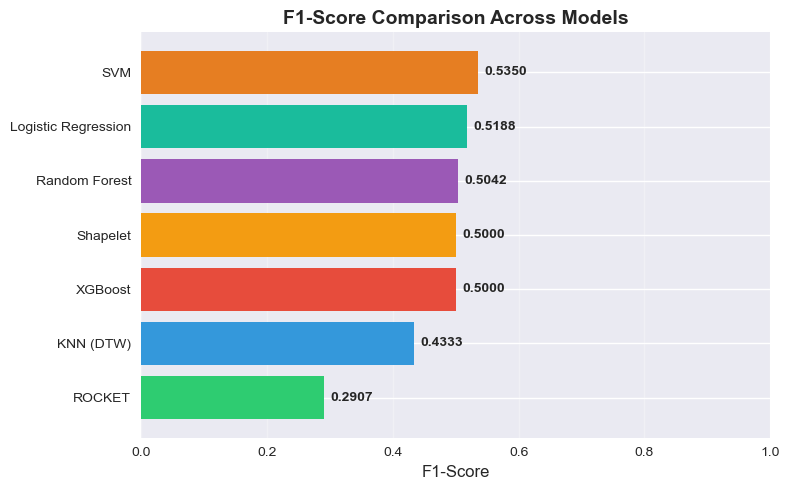

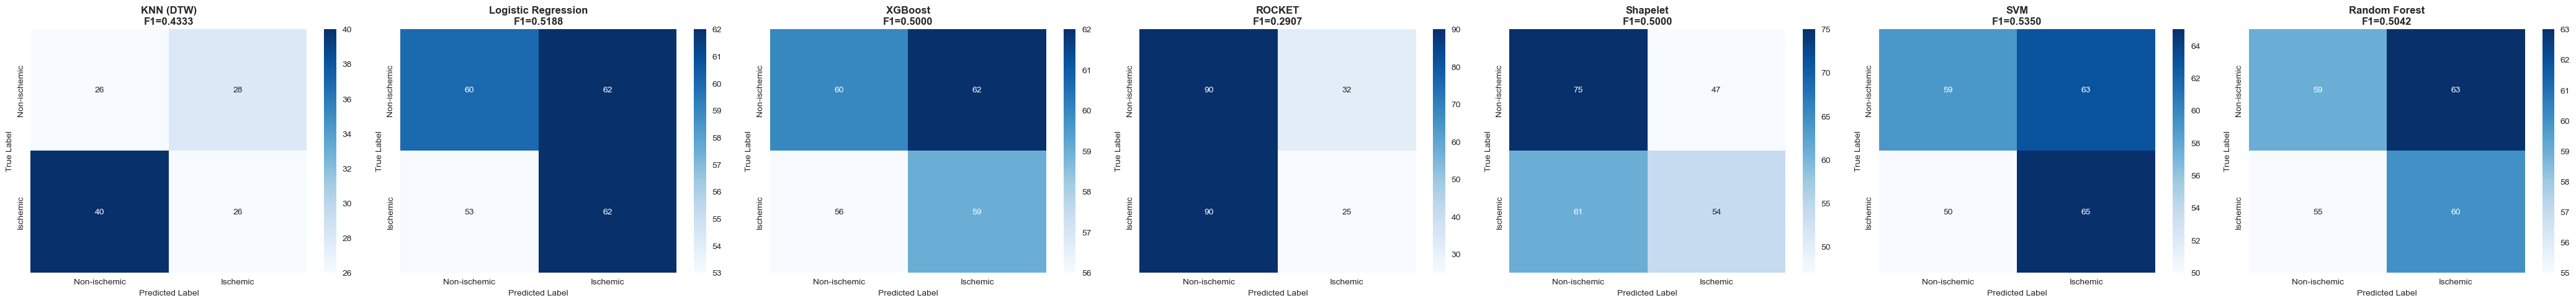

In [78]:
fig1, ax1 = plt.subplots(figsize=(8, 5))
f1_scores = comparison_df['f1'].sort_values(ascending=True)
colors = ['#2ecc71', '#3498db', '#e74c3c', '#f39c12', '#9b59b6', '#1abc9c', '#e67e22']
bars = ax1.barh(f1_scores.index, f1_scores.values, color=colors[:len(f1_scores)])
ax1.set_xlabel('F1-Score', fontsize=12)
ax1.set_title('F1-Score Comparison Across Models', fontsize=14, fontweight='bold')
ax1.set_xlim([0, 1])
ax1.grid(axis='x', alpha=0.3)

for i, (idx, val) in enumerate(f1_scores.items()):
    ax1.text(val + 0.01, i, f'{val:.4f}', va='center', fontweight='bold')

plt.tight_layout()
plt.savefig(plots_path / '6.tsc_f1_scores.png', dpi=300, bbox_inches='tight')
plt.show()

n_models = len(confusion_matrices)
fig2, axes2 = plt.subplots(1, n_models, figsize=(6*n_models, 5))
if n_models == 1:
    axes2 = [axes2]
for idx, (model_name, cm) in enumerate(confusion_matrices.items()):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes2[idx],
                xticklabels=['Non-ischemic', 'Ischemic'],
                yticklabels=['Non-ischemic', 'Ischemic'])
    axes2[idx].set_title(f'{model_name}\nF1={results[model_name]["f1"]:.4f}', 
                        fontsize=12, fontweight='bold')
    axes2[idx].set_ylabel('True Label', fontsize=10)
    axes2[idx].set_xlabel('Predicted Label', fontsize=10)

plt.tight_layout()
plt.savefig(plots_path / '6.tsc_confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

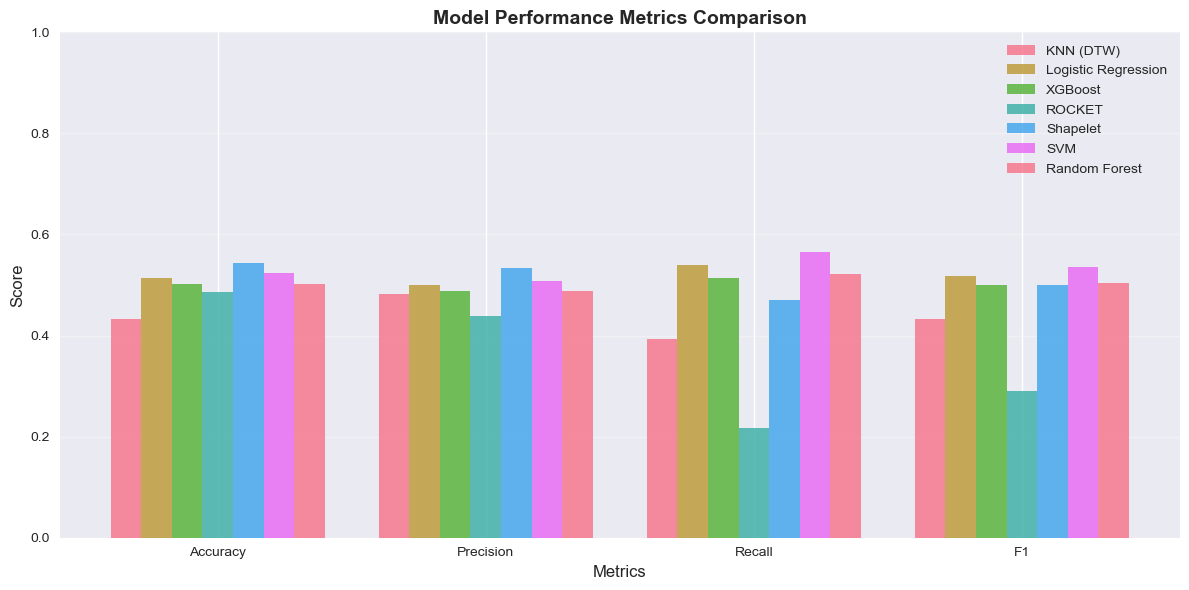

In [79]:
fig, ax = plt.subplots(figsize=(12, 6))

metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1']
x = np.arange(len(metrics_to_plot))
n_models = len(comparison_df.index)
width = 0.8 / n_models  # Adjust width based on number of models

for i, model_name in enumerate(comparison_df.index):
    values = [comparison_df.loc[model_name, metric] for metric in metrics_to_plot]
    offset = (i - n_models/2 + 0.5) * width
    ax.bar(x + offset, values, width, label=model_name, alpha=0.8)

ax.set_xlabel('Metrics', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Model Performance Metrics Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels([m.replace('_', ' ').title() for m in metrics_to_plot])
ax.legend()
ax.set_ylim([0, 1])
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(plots_path / '6.tsc_metrics_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

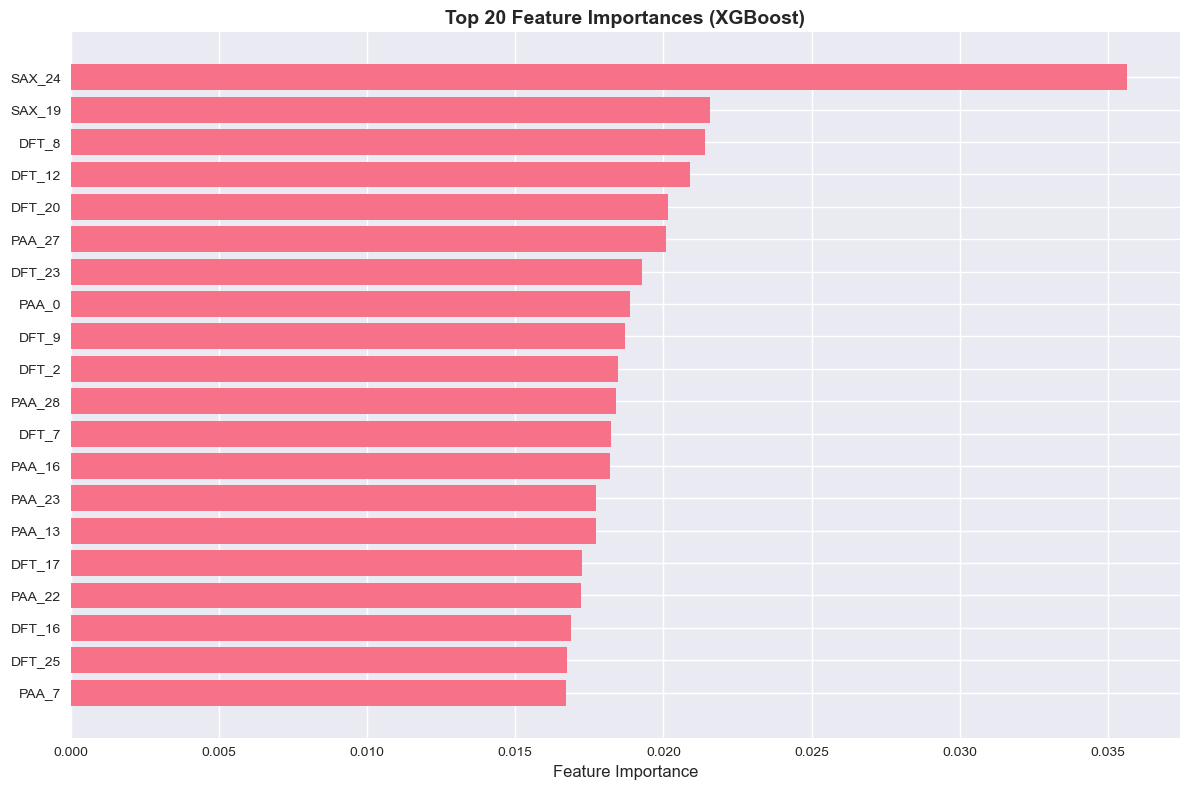


Top 10 Most Important Features:
  1. SAX_24: 0.0357
  2. SAX_19: 0.0216
  3. DFT_8: 0.0214
  4. DFT_12: 0.0209
  5. DFT_20: 0.0201
  6. PAA_27: 0.0201
  7. DFT_23: 0.0193
  8. PAA_0: 0.0189
  9. DFT_9: 0.0187
  10. DFT_2: 0.0185


In [82]:
if hasattr(xgb_model, 'feature_importances_'):
    feature_names = (
        [f'PAA_{i}' for i in range(n_paa_segments)] +
        [f'SAX_{i}' for i in range(n_sax_segments)] +
        [f'DFT_{i}' for i in range(n_dft_coefficients)]
    )
    
    importances = xgb_model.feature_importances_
    indices = np.argsort(importances)[::-1][:20]
    
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.barh(range(len(indices)), importances[indices], align='center')
    ax.set_yticks(range(len(indices)))
    ax.set_yticklabels([feature_names[i] for i in indices])
    ax.set_xlabel('Feature Importance', fontsize=12)
    ax.set_title('Top 20 Feature Importances (XGBoost)', fontsize=14, fontweight='bold')
    ax.invert_yaxis()
    plt.tight_layout()
    plt.savefig(plots_path / '6.tsc_feature_importances.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\nTop 10 Most Important Features:")
    for i, idx in enumerate(indices[:10]):
        print(f"  {i+1}. {feature_names[idx]}: {importances[idx]:.4f}")

Computing SVM feature importance (permutation-based)...


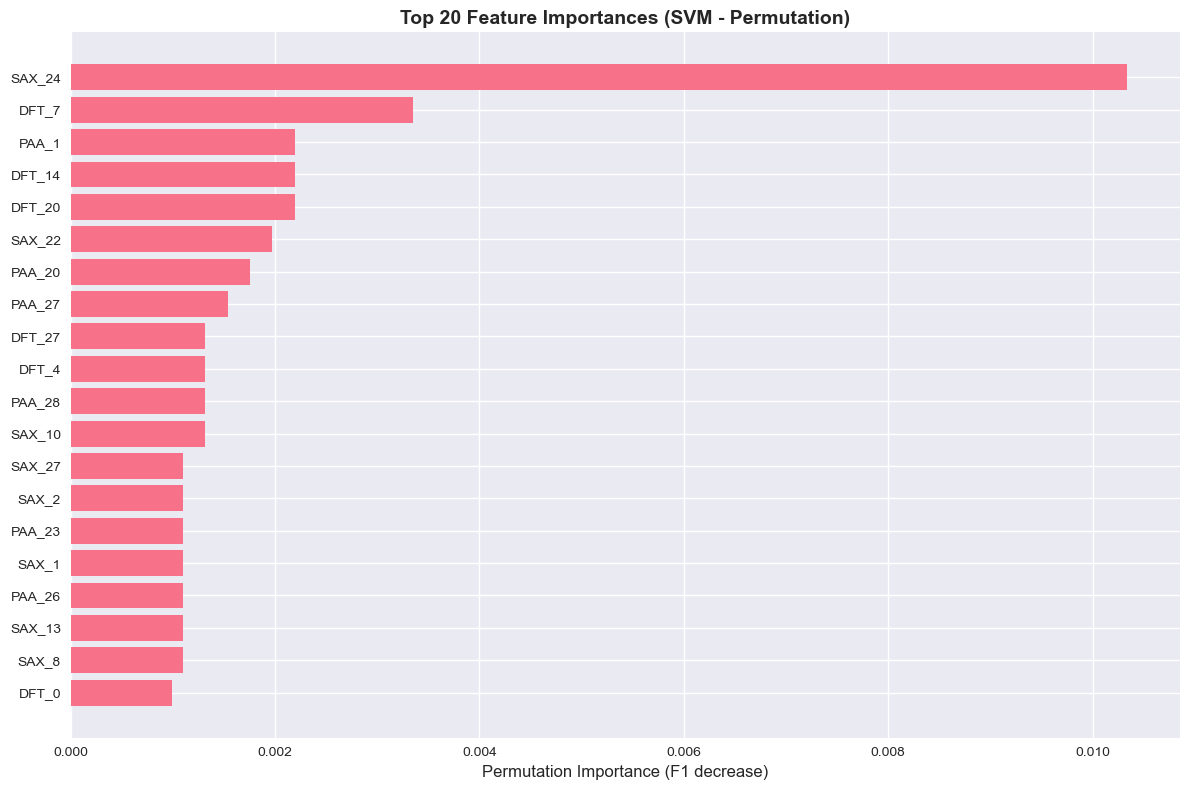


Top 10 Most Important Features (SVM):
  1. SAX_24: 0.0103
  2. DFT_7: 0.0033
  3. PAA_1: 0.0022
  4. DFT_14: 0.0022
  5. DFT_20: 0.0022
  6. SAX_22: 0.0020
  7. PAA_20: 0.0018
  8. PAA_27: 0.0015
  9. DFT_27: 0.0013
  10. DFT_4: 0.0013


In [83]:
from sklearn.inspection import permutation_importance

# SVM feature importance via permutation importance
print("Computing SVM feature importance (permutation-based)...")

feature_names = (
    [f'PAA_{i}' for i in range(n_paa_segments)] +
    [f'SAX_{i}' for i in range(n_sax_segments)] +
    [f'DFT_{i}' for i in range(n_dft_coefficients)]
)

# Compute permutation importance (uses test set)
perm_importance = permutation_importance(
    svm_model, X_test_features_scaled, y_test,
    n_repeats=10, random_state=42, n_jobs=-1, scoring='f1'
)

importances = perm_importance.importances_mean
indices = np.argsort(importances)[::-1][:20]

fig, ax = plt.subplots(figsize=(12, 8))
ax.barh(range(len(indices)), importances[indices], align='center')
ax.set_yticks(range(len(indices)))
ax.set_yticklabels([feature_names[i] for i in indices])
ax.set_xlabel('Permutation Importance (F1 decrease)', fontsize=12)
ax.set_title('Top 20 Feature Importances (SVM - Permutation)', fontsize=14, fontweight='bold')
ax.invert_yaxis()
plt.tight_layout()
plt.savefig(plots_path / '6.tsc_feature_importances_svm.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nTop 10 Most Important Features (SVM):")
for i, idx in enumerate(indices[:10]):
    print(f"  {i+1}. {feature_names[idx]}: {importances[idx]:.4f}")